In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import os

file_names = os.listdir('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/')
img_paths = ['/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + file_name for file_name in file_names]
len(img_paths)

202599

In [3]:
import matplotlib.pyplot as plt

def show_images(file_names, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(file_names):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_np)


def show_three_images(batch, num_samples=4):
    """
    Hiển thị 3 ảnh (gt_image, cond_image, mask_image) cho từng mẫu.
    Số mẫu hiển thị = num_samples (mặc định 4).
    """
    gt_image = batch['gt_image']     # (B, C, H, W)
    masks = batch['mask']   # (B, C, H, W)
    mask_image = batch['mask_image']   # (B, C, H, W)

    # Nếu các tensor ở GPU thì chuyển về CPU
    if gt_image.is_cuda:
        gt_image = gt_image.cpu()
        cond_image = cond_image.cpu()
        mask_image = mask_image.cpu()

    # Tính số hàng = num_samples, số cột = 3
    rows, cols = num_samples, 3
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Lấy từng ảnh
        img_gt = gt_image[i]
        mask = masks[i]
        img_mask = mask_image[i]

        # Unnormalize mỗi ảnh: x = x*0.5 + 0.5  (do bạn Normalize(mean=0.5, std=0.5))
        img_gt = img_gt * 0.5 + 0.5
        img_mask = img_mask * 0.5 + 0.5

        # Chuyển (C,H,W) -> (H,W,C) để hiển thị
        np_gt = img_gt.permute(1, 2, 0).numpy()
        np_mask = img_mask.permute(1, 2, 0).numpy()
        mask = np.transpose(mask, (1, 2, 0))

        # Vẽ gt_image
        plt.subplot(rows, cols, i * cols + 1)
        plt.imshow(np_gt)
        plt.title("GT Image")
        plt.axis("off")

        # Vẽ cond_image
        plt.subplot(rows, cols, i * cols + 2)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis("off")

        # Vẽ mask_image
        plt.subplot(rows, cols, i * cols + 3)
        plt.imshow(np_mask)
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Create data loader

In [4]:
num_train, num_val = 100, 100  # demo with small data
train_imgpaths = img_paths[: num_train]
val_imgpaths = img_paths[num_train: num_train + num_val]

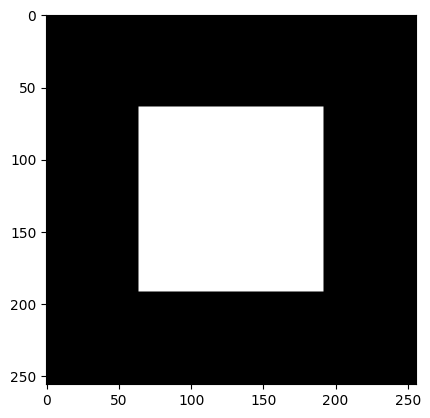

In [5]:
def bbox2mask(img_shape, bbox):
    """
    img_shape: (h, w, c)
    bbox: (x1, y1, w, h)
    """
    h_img, w_img = img_shape
    x1, y1, w, h = bbox
    mask = np.zeros((h_img, w_img), dtype=np.uint8)
    mask[y1:y1 + h, x1:x1 + w] = 1
    return mask


test_mask = bbox2mask((256, 256), (256//4, 256//4, 256//2, 256//2))
plt.imshow(test_mask, cmap='gray')

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InpaintingDataset():
    def __init__(self, img_paths, mask_mode, data_len=100, image_size=[256, 256]):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths

        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.mask_mode = mask_mode
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()  # 256x256
        cond_image = img * (1. - mask) + mask * torch.randn_like(img)  # trung tâm: mask (noise)
        mask_img = img * (1. - mask) + mask       # trung tâm: 1, rìa: ảnh
    
        return {
            'gt_image': img,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }


    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        if self.mask_mode == 'center':
            h, w = self.image_size
            mask = bbox2mask(self.image_size, (h//4, w//4, h//2, w//2))
        else:
            raise NotImplementedError(
                f'Mask mode {self.mask_mode} has not been implemented.')
        return torch.from_numpy(mask).unsqueeze(0)

In [7]:
from torch.utils.data import DataLoader
train_dataset = InpaintingDataset(train_imgpaths, mask_mode='center')
val_dataset = InpaintingDataset(val_imgpaths, mask_mode='center')

BATCH_SIZE = 4
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

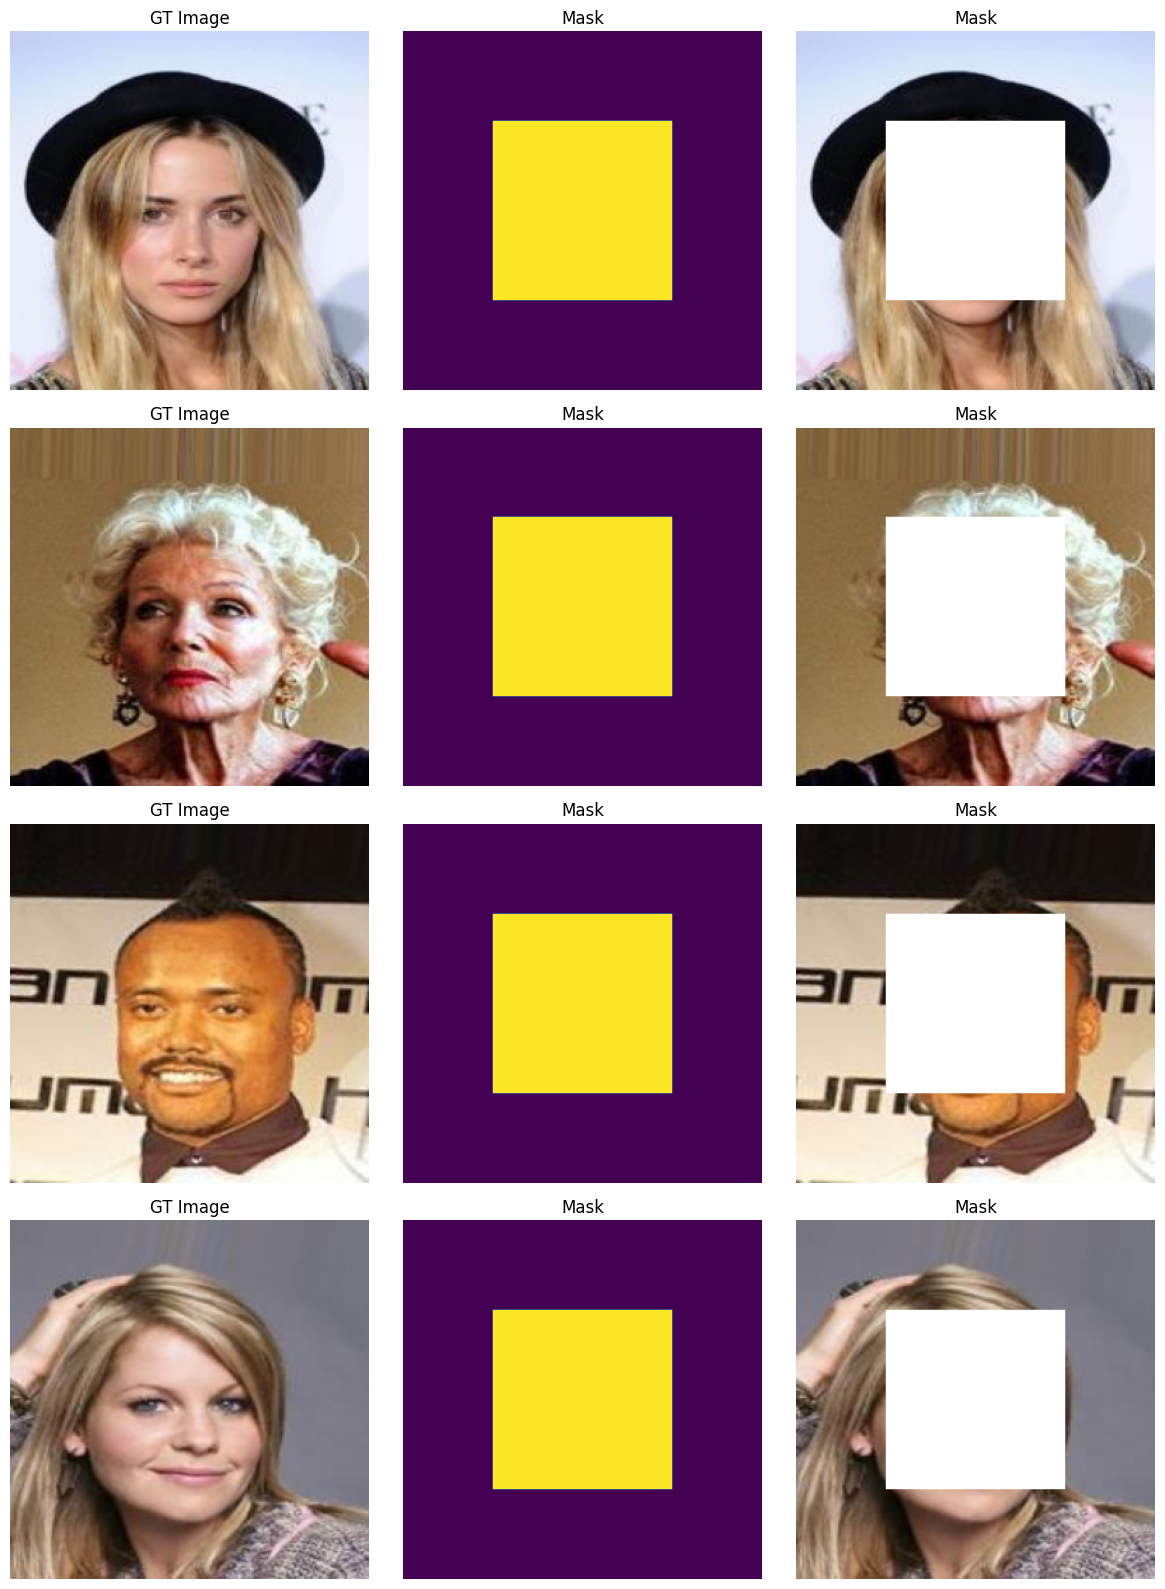

In [8]:
# Lấy batch
data_iter = iter(train_loader)
batch = next(data_iter)

# Gọi hàm hiển thị 3 loại ảnh
show_three_images(batch, num_samples=4)

## Trainning

In [9]:
! pip install -q torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
import time
from torchcfm.models.unet import UNetModel
from tqdm import tqdm
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNetModel(dim=(3, 256, 256), num_channels=32,
                  num_res_blocks=1).to(device)
n_epochs = 1000

def mse_loss(output, target):
    return F.mse_loss(output, target)

class Trainer():
    def __init__(self, model, optimizer_params, train_loader, val_loader, epochs, device, save_model):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()), **optimizer_params)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        self.save_model = save_model + "/best_model.pth"

    def train_step(self):
        self.model.train()
        losses = []
        for batch in tqdm(self.train_loader, desc="Training"):
            x1 = batch["gt_image"].to(self.device)
            mask = batch["mask"].to(self.device)
            x0 = torch.randn_like(x1).to(self.device)

            x_noise = (1.0 - mask) * x1 + mask * x0
            t = torch.rand(x0.shape[0], 1, 1, 1).to(self.device)
            xt = t * x1 + (1 - t) * x_noise
            ut = x1 - x_noise

            t = t.squeeze()
            x_cond = xt * mask + (1.0 - mask) * x1 # trung tâm lấy xt, rìa lấy x1 . Nghĩa là xT đã là ảnh có noise và ảnh condition là rìa nên ở model mình chỉ thấy đẩy 1 input
            vt = self.model(t, x_cond)

            loss = torch.mean(((vt - ut) ** 2) * mask)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
        return sum(losses) / len(losses)

    def val_step(self):
        self.model.eval()
        losses = []
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                x1 = batch["gt_image"].to(self.device)
                mask = batch["mask"].to(self.device)
                x0 = torch.randn_like(x1).to(self.device)

                x_noise = (1.0 - mask) * x1 + mask * x0
                t = torch.rand(x0.shape[0], 1, 1, 1).to(self.device)
                xt = t * x1 + (1 - t) * x_noise
                ut = x1 - x_noise

                t = t.squeeze()
                x_cond = xt * mask + (1.0 - mask) * x1
                vt = self.model(t, x_cond)

                loss = torch.mean(((vt - ut) ** 2) * mask)

                losses.append(loss.item())
        return sum(losses) / len(losses)

    def train(self):
        best_loss = float('inf') 
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            train_loss = self.train_step()
            val_loss = self.val_step()
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), self.save_model)
            print("-" * 59)
            print("| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} | Valid Loss {:8.3f} |".format(
                epoch + 1, time.time() - epoch_start_time, train_loss, val_loss,
            ))
            print("-" * 59)
        self.model.load_state_dict(torch.load(self.save_model))
        print("Training complete. Best model loaded.")

In [11]:
optimizer_params = {"lr": 0.001}
trainer = Trainer(model, optimizer_params, train_loader, val_loader,
                  epochs=n_epochs, device=device, save_model="/kaggle/working/")
trainer.train()

Validation: 100%|██████████| 25/25 [00:01<00:00, 14.20it/s]


-----------------------------------------------------------
| End of epoch   1 | Time:  7.20s | Train Loss    0.188 | Valid Loss    0.118 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch   2 | Time:  5.28s | Train Loss    0.088 | Valid Loss    0.077 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


-----------------------------------------------------------
| End of epoch   3 | Time:  5.19s | Train Loss    0.067 | Valid Loss    0.069 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.70it/s]


-----------------------------------------------------------
| End of epoch   4 | Time:  5.18s | Train Loss    0.057 | Valid Loss    0.070 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch   5 | Time:  5.20s | Train Loss    0.062 | Valid Loss    0.069 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch   6 | Time:  5.24s | Train Loss    0.047 | Valid Loss    0.051 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch   7 | Time:  5.20s | Train Loss    0.055 | Valid Loss    0.059 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch   8 | Time:  5.24s | Train Loss    0.047 | Valid Loss    0.050 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch   9 | Time:  5.28s | Train Loss    0.042 | Valid Loss    0.051 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch  10 | Time:  5.27s | Train Loss    0.044 | Valid Loss    0.054 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch  11 | Time:  5.25s | Train Loss    0.049 | Valid Loss    0.046 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.90it/s]


-----------------------------------------------------------
| End of epoch  12 | Time:  5.24s | Train Loss    0.040 | Valid Loss    0.039 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.91it/s]


-----------------------------------------------------------
| End of epoch  13 | Time:  5.21s | Train Loss    0.038 | Valid Loss    0.046 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch  14 | Time:  5.20s | Train Loss    0.046 | Valid Loss    0.047 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch  15 | Time:  5.34s | Train Loss    0.040 | Valid Loss    0.054 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.60it/s]


-----------------------------------------------------------
| End of epoch  16 | Time:  5.33s | Train Loss    0.041 | Valid Loss    0.040 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch  17 | Time:  5.31s | Train Loss    0.045 | Valid Loss    0.055 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch  18 | Time:  5.29s | Train Loss    0.047 | Valid Loss    0.042 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch  19 | Time:  5.38s | Train Loss    0.045 | Valid Loss    0.035 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch  20 | Time:  5.33s | Train Loss    0.045 | Valid Loss    0.049 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch  21 | Time:  5.35s | Train Loss    0.042 | Valid Loss    0.036 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.86it/s]


-----------------------------------------------------------
| End of epoch  22 | Time:  5.48s | Train Loss    0.042 | Valid Loss    0.037 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch  23 | Time:  5.36s | Train Loss    0.040 | Valid Loss    0.038 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch  24 | Time:  5.41s | Train Loss    0.040 | Valid Loss    0.036 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch  25 | Time:  5.40s | Train Loss    0.038 | Valid Loss    0.040 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch  26 | Time:  5.47s | Train Loss    0.040 | Valid Loss    0.045 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch  27 | Time:  5.49s | Train Loss    0.037 | Valid Loss    0.039 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch  28 | Time:  5.52s | Train Loss    0.032 | Valid Loss    0.037 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch  29 | Time:  5.60s | Train Loss    0.032 | Valid Loss    0.032 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


-----------------------------------------------------------
| End of epoch  30 | Time:  5.57s | Train Loss    0.029 | Valid Loss    0.032 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch  31 | Time:  5.51s | Train Loss    0.032 | Valid Loss    0.035 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch  32 | Time:  5.45s | Train Loss    0.039 | Valid Loss    0.035 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


-----------------------------------------------------------
| End of epoch  33 | Time:  5.47s | Train Loss    0.035 | Valid Loss    0.038 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch  34 | Time:  5.48s | Train Loss    0.033 | Valid Loss    0.033 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch  35 | Time:  5.39s | Train Loss    0.033 | Valid Loss    0.033 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch  36 | Time:  5.41s | Train Loss    0.031 | Valid Loss    0.033 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch  37 | Time:  5.51s | Train Loss    0.032 | Valid Loss    0.033 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch  38 | Time:  5.49s | Train Loss    0.034 | Valid Loss    0.036 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.50it/s]


-----------------------------------------------------------
| End of epoch  39 | Time:  5.59s | Train Loss    0.034 | Valid Loss    0.034 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch  40 | Time:  5.42s | Train Loss    0.032 | Valid Loss    0.043 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch  41 | Time:  5.54s | Train Loss    0.032 | Valid Loss    0.031 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch  42 | Time:  5.50s | Train Loss    0.033 | Valid Loss    0.038 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch  43 | Time:  5.49s | Train Loss    0.033 | Valid Loss    0.031 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch  44 | Time:  5.48s | Train Loss    0.032 | Valid Loss    0.037 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch  45 | Time:  5.53s | Train Loss    0.029 | Valid Loss    0.031 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch  46 | Time:  5.42s | Train Loss    0.032 | Valid Loss    0.032 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch  47 | Time:  5.43s | Train Loss    0.032 | Valid Loss    0.032 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch  48 | Time:  5.47s | Train Loss    0.034 | Valid Loss    0.036 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch  49 | Time:  5.51s | Train Loss    0.031 | Valid Loss    0.031 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.81it/s]


-----------------------------------------------------------
| End of epoch  50 | Time:  5.55s | Train Loss    0.036 | Valid Loss    0.029 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch  51 | Time:  5.57s | Train Loss    0.034 | Valid Loss    0.032 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch  52 | Time:  5.47s | Train Loss    0.163 | Valid Loss    0.309 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch  53 | Time:  5.47s | Train Loss    0.306 | Valid Loss    0.306 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch  54 | Time:  5.46s | Train Loss    0.295 | Valid Loss    0.297 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch  55 | Time:  5.45s | Train Loss    0.290 | Valid Loss    0.291 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch  56 | Time:  5.46s | Train Loss    0.290 | Valid Loss    0.295 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch  57 | Time:  5.47s | Train Loss    0.287 | Valid Loss    0.287 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch  58 | Time:  5.43s | Train Loss    0.284 | Valid Loss    0.287 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.60it/s]


-----------------------------------------------------------
| End of epoch  59 | Time:  5.53s | Train Loss    0.284 | Valid Loss    0.283 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch  60 | Time:  5.46s | Train Loss    0.284 | Valid Loss    0.283 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch  61 | Time:  5.51s | Train Loss    0.282 | Valid Loss    0.284 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.05it/s]


-----------------------------------------------------------
| End of epoch  62 | Time:  5.56s | Train Loss    0.282 | Valid Loss    0.283 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch  63 | Time:  5.46s | Train Loss    0.281 | Valid Loss    0.284 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch  64 | Time:  5.45s | Train Loss    0.282 | Valid Loss    0.288 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch  65 | Time:  5.43s | Train Loss    0.281 | Valid Loss    0.280 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch  66 | Time:  5.43s | Train Loss    0.280 | Valid Loss    0.280 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch  67 | Time:  5.45s | Train Loss    0.276 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.41it/s]


-----------------------------------------------------------
| End of epoch  68 | Time:  5.58s | Train Loss    0.276 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch  69 | Time:  5.52s | Train Loss    0.276 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch  70 | Time:  5.48s | Train Loss    0.275 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch  71 | Time:  5.55s | Train Loss    0.276 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch  72 | Time:  5.49s | Train Loss    0.276 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.64it/s]


-----------------------------------------------------------
| End of epoch  73 | Time:  5.52s | Train Loss    0.274 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch  74 | Time:  5.53s | Train Loss    0.274 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch  75 | Time:  5.55s | Train Loss    0.275 | Valid Loss    0.280 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch  76 | Time:  5.42s | Train Loss    0.277 | Valid Loss    0.281 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch  77 | Time:  5.43s | Train Loss    0.280 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


-----------------------------------------------------------
| End of epoch  78 | Time:  5.45s | Train Loss    0.275 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


-----------------------------------------------------------
| End of epoch  79 | Time:  5.55s | Train Loss    0.274 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch  80 | Time:  5.48s | Train Loss    0.274 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch  81 | Time:  5.47s | Train Loss    0.272 | Valid Loss    0.280 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.45it/s]


-----------------------------------------------------------
| End of epoch  82 | Time:  5.58s | Train Loss    0.275 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch  83 | Time:  5.45s | Train Loss    0.273 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch  84 | Time:  5.50s | Train Loss    0.273 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.51it/s]


-----------------------------------------------------------
| End of epoch  85 | Time:  5.62s | Train Loss    0.270 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch  86 | Time:  5.50s | Train Loss    0.272 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch  87 | Time:  5.42s | Train Loss    0.275 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


-----------------------------------------------------------
| End of epoch  88 | Time:  5.48s | Train Loss    0.274 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch  89 | Time:  5.41s | Train Loss    0.272 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch  90 | Time:  5.50s | Train Loss    0.271 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch  91 | Time:  5.45s | Train Loss    0.271 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.13it/s]


-----------------------------------------------------------
| End of epoch  92 | Time:  5.56s | Train Loss    0.271 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


-----------------------------------------------------------
| End of epoch  93 | Time:  6.49s | Train Loss    0.270 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.01it/s]


-----------------------------------------------------------
| End of epoch  94 | Time:  5.64s | Train Loss    0.270 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch  95 | Time:  5.45s | Train Loss    0.272 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch  96 | Time:  5.46s | Train Loss    0.271 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch  97 | Time:  5.52s | Train Loss    0.270 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch  98 | Time:  5.40s | Train Loss    0.271 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch  99 | Time:  5.38s | Train Loss    0.270 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 100 | Time:  5.41s | Train Loss    0.270 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 101 | Time:  5.42s | Train Loss    0.270 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.33it/s]


-----------------------------------------------------------
| End of epoch 102 | Time:  5.52s | Train Loss    0.270 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.64it/s]


-----------------------------------------------------------
| End of epoch 103 | Time:  5.50s | Train Loss    0.270 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch 104 | Time:  5.46s | Train Loss    0.270 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch 105 | Time:  5.49s | Train Loss    0.271 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 106 | Time:  5.44s | Train Loss    0.273 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 107 | Time:  5.46s | Train Loss    0.272 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.86it/s]


-----------------------------------------------------------
| End of epoch 108 | Time:  5.50s | Train Loss    0.271 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch 109 | Time:  5.49s | Train Loss    0.269 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 110 | Time:  5.43s | Train Loss    0.270 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 111 | Time:  5.42s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 112 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 113 | Time:  5.43s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 114 | Time:  5.50s | Train Loss    0.269 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


-----------------------------------------------------------
| End of epoch 115 | Time:  5.50s | Train Loss    0.269 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 116 | Time:  5.43s | Train Loss    0.269 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 117 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 118 | Time:  5.41s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 119 | Time:  5.48s | Train Loss    0.270 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 120 | Time:  5.48s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 121 | Time:  5.44s | Train Loss    0.269 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 122 | Time:  5.42s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 123 | Time:  5.49s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 124 | Time:  5.44s | Train Loss    0.270 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch 125 | Time:  5.50s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 126 | Time:  5.53s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 127 | Time:  5.50s | Train Loss    0.270 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 128 | Time:  5.48s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 129 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 130 | Time:  5.50s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.78it/s]


-----------------------------------------------------------
| End of epoch 131 | Time:  5.53s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 132 | Time:  5.37s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 133 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 134 | Time:  5.42s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 135 | Time:  5.42s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 136 | Time:  5.47s | Train Loss    0.270 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 137 | Time:  5.48s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 138 | Time:  5.44s | Train Loss    0.270 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 139 | Time:  5.48s | Train Loss    0.270 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 140 | Time:  5.40s | Train Loss    0.271 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 141 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 142 | Time:  5.43s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 143 | Time:  5.47s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 144 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 145 | Time:  5.42s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 146 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 147 | Time:  5.46s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 148 | Time:  5.40s | Train Loss    0.268 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 149 | Time:  5.45s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 150 | Time:  5.42s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 151 | Time:  5.43s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 152 | Time:  5.43s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 153 | Time:  5.38s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 154 | Time:  5.39s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 155 | Time:  5.44s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 156 | Time:  5.41s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 157 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 158 | Time:  5.45s | Train Loss    0.266 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 159 | Time:  5.44s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.38it/s]


-----------------------------------------------------------
| End of epoch 160 | Time:  5.53s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 161 | Time:  5.46s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 162 | Time:  5.40s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 163 | Time:  5.45s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.65it/s]


-----------------------------------------------------------
| End of epoch 164 | Time:  5.38s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 165 | Time:  5.40s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 166 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 167 | Time:  5.39s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.89it/s]


-----------------------------------------------------------
| End of epoch 168 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 169 | Time:  5.39s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 170 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 171 | Time:  5.45s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 172 | Time:  5.58s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 173 | Time:  5.42s | Train Loss    0.266 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.80it/s]


-----------------------------------------------------------
| End of epoch 174 | Time:  5.47s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 175 | Time:  5.39s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 176 | Time:  5.39s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.64it/s]


-----------------------------------------------------------
| End of epoch 177 | Time:  5.39s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 178 | Time:  5.46s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 179 | Time:  5.41s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 180 | Time:  5.46s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 181 | Time:  5.43s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 182 | Time:  5.39s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


-----------------------------------------------------------
| End of epoch 183 | Time:  5.39s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 184 | Time:  5.43s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch 185 | Time:  5.42s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.64it/s]


-----------------------------------------------------------
| End of epoch 186 | Time:  5.38s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.63it/s]


-----------------------------------------------------------
| End of epoch 187 | Time:  5.37s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.68it/s]


-----------------------------------------------------------
| End of epoch 188 | Time:  5.40s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.02it/s]


-----------------------------------------------------------
| End of epoch 189 | Time:  5.58s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 190 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 191 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 192 | Time:  5.44s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


-----------------------------------------------------------
| End of epoch 193 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.89it/s]


-----------------------------------------------------------
| End of epoch 194 | Time:  5.46s | Train Loss    0.266 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.16it/s]


-----------------------------------------------------------
| End of epoch 195 | Time:  5.58s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 196 | Time:  5.41s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 197 | Time:  5.36s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 198 | Time:  5.42s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 199 | Time:  5.37s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 200 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 201 | Time:  5.49s | Train Loss    0.263 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 202 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 203 | Time:  5.43s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.50it/s]


-----------------------------------------------------------
| End of epoch 204 | Time:  5.49s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 205 | Time:  5.47s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.14it/s]


-----------------------------------------------------------
| End of epoch 206 | Time:  5.54s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 207 | Time:  5.50s | Train Loss    0.265 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 208 | Time:  5.40s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 209 | Time:  5.41s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 210 | Time:  5.42s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 211 | Time:  5.41s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 212 | Time:  5.49s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 213 | Time:  5.55s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.61it/s]


-----------------------------------------------------------
| End of epoch 214 | Time:  5.51s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 215 | Time:  5.42s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 216 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.19it/s]


-----------------------------------------------------------
| End of epoch 217 | Time:  5.55s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.15it/s]


-----------------------------------------------------------
| End of epoch 218 | Time:  5.73s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 219 | Time:  5.44s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch 220 | Time:  5.41s | Train Loss    0.263 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 221 | Time:  5.37s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 222 | Time:  5.41s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 223 | Time:  5.44s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 224 | Time:  5.51s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 225 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 226 | Time:  5.40s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 227 | Time:  5.43s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 228 | Time:  5.41s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 229 | Time:  5.41s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 230 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.60it/s]


-----------------------------------------------------------
| End of epoch 231 | Time:  5.40s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.60it/s]


-----------------------------------------------------------
| End of epoch 232 | Time:  5.37s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 233 | Time:  5.38s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 234 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.54it/s]


-----------------------------------------------------------
| End of epoch 235 | Time:  5.38s | Train Loss    0.265 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


-----------------------------------------------------------
| End of epoch 236 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 237 | Time:  5.41s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 238 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 239 | Time:  5.44s | Train Loss    0.264 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.57it/s]


-----------------------------------------------------------
| End of epoch 240 | Time:  5.45s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 241 | Time:  5.40s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 242 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch 243 | Time:  5.39s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 244 | Time:  5.39s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 245 | Time:  5.36s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 246 | Time:  5.53s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


-----------------------------------------------------------
| End of epoch 247 | Time:  5.47s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 248 | Time:  5.49s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


-----------------------------------------------------------
| End of epoch 249 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 250 | Time:  5.42s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 251 | Time:  5.43s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 252 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.54it/s]


-----------------------------------------------------------
| End of epoch 253 | Time:  5.50s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 254 | Time:  5.41s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 255 | Time:  5.39s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 256 | Time:  5.40s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.57it/s]


-----------------------------------------------------------
| End of epoch 257 | Time:  5.46s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 258 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.10it/s]


-----------------------------------------------------------
| End of epoch 259 | Time:  5.58s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 260 | Time:  5.46s | Train Loss    0.262 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 261 | Time:  5.45s | Train Loss    0.263 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 262 | Time:  5.44s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 263 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch 264 | Time:  5.54s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 265 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch 266 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 267 | Time:  5.41s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 268 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 269 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 270 | Time:  5.44s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 271 | Time:  5.53s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 272 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 273 | Time:  5.41s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 274 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 275 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


-----------------------------------------------------------
| End of epoch 276 | Time:  5.50s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 277 | Time:  5.44s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 278 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.64it/s]


-----------------------------------------------------------
| End of epoch 279 | Time:  5.49s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 280 | Time:  5.56s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 281 | Time:  5.46s | Train Loss    0.261 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.66it/s]


-----------------------------------------------------------
| End of epoch 282 | Time:  5.48s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 283 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 284 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 285 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 286 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 287 | Time:  5.46s | Train Loss    0.261 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 288 | Time:  5.54s | Train Loss    0.262 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


-----------------------------------------------------------
| End of epoch 289 | Time:  5.51s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 290 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 291 | Time:  5.47s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 292 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.34it/s]


-----------------------------------------------------------
| End of epoch 293 | Time:  5.53s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 294 | Time:  5.50s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 295 | Time:  5.45s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 296 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 297 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch 298 | Time:  5.41s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.39it/s]


-----------------------------------------------------------
| End of epoch 299 | Time:  5.55s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 300 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 301 | Time:  5.56s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 302 | Time:  5.55s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 303 | Time:  5.48s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 304 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.40it/s]


-----------------------------------------------------------
| End of epoch 305 | Time:  5.52s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 306 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 307 | Time:  5.46s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 308 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 309 | Time:  5.39s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 310 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.53it/s]


-----------------------------------------------------------
| End of epoch 311 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 312 | Time:  5.42s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


-----------------------------------------------------------
| End of epoch 313 | Time:  5.46s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 314 | Time:  5.45s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 315 | Time:  5.46s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 316 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 317 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 318 | Time:  5.43s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 319 | Time:  5.40s | Train Loss    0.261 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 320 | Time:  5.40s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 321 | Time:  5.42s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 322 | Time:  5.45s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


-----------------------------------------------------------
| End of epoch 323 | Time:  5.55s | Train Loss    0.261 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.36it/s]


-----------------------------------------------------------
| End of epoch 324 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 325 | Time:  5.41s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.77it/s]


-----------------------------------------------------------
| End of epoch 326 | Time:  5.75s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 327 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.97it/s]


-----------------------------------------------------------
| End of epoch 328 | Time:  5.58s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 329 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 330 | Time:  5.52s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


-----------------------------------------------------------
| End of epoch 331 | Time:  5.49s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 332 | Time:  5.57s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


-----------------------------------------------------------
| End of epoch 333 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 334 | Time:  5.55s | Train Loss    0.261 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


-----------------------------------------------------------
| End of epoch 335 | Time:  5.54s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 336 | Time:  5.56s | Train Loss    0.260 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch 337 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 338 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


-----------------------------------------------------------
| End of epoch 339 | Time:  5.51s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 340 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 341 | Time:  5.54s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 342 | Time:  5.48s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


-----------------------------------------------------------
| End of epoch 343 | Time:  5.47s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.61it/s]


-----------------------------------------------------------
| End of epoch 344 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.33it/s]


-----------------------------------------------------------
| End of epoch 345 | Time:  5.52s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 346 | Time:  5.52s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 347 | Time:  5.44s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 348 | Time:  5.47s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 349 | Time:  5.45s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch 350 | Time:  5.51s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 351 | Time:  5.51s | Train Loss    0.260 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.40it/s]


-----------------------------------------------------------
| End of epoch 352 | Time:  5.53s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 353 | Time:  5.42s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 354 | Time:  5.40s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


-----------------------------------------------------------
| End of epoch 355 | Time:  5.54s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.16it/s]


-----------------------------------------------------------
| End of epoch 356 | Time:  5.62s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 357 | Time:  5.64s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 358 | Time:  5.60s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 359 | Time:  5.55s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


-----------------------------------------------------------
| End of epoch 360 | Time:  5.51s | Train Loss    0.259 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 361 | Time:  5.44s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.71it/s]


-----------------------------------------------------------
| End of epoch 362 | Time:  5.45s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 363 | Time:  5.50s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 364 | Time:  5.43s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 365 | Time:  5.40s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 366 | Time:  5.39s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 367 | Time:  5.48s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.43it/s]


-----------------------------------------------------------
| End of epoch 368 | Time:  5.55s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 369 | Time:  5.45s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 370 | Time:  5.42s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 371 | Time:  5.39s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch 372 | Time:  5.40s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 373 | Time:  5.41s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.29it/s]


-----------------------------------------------------------
| End of epoch 374 | Time:  5.56s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 375 | Time:  5.47s | Train Loss    0.260 | Valid Loss    0.262 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 376 | Time:  5.42s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 377 | Time:  5.51s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 378 | Time:  5.42s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 379 | Time:  5.48s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.83it/s]


-----------------------------------------------------------
| End of epoch 380 | Time:  5.53s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 381 | Time:  5.48s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 382 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 383 | Time:  5.41s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.40it/s]


-----------------------------------------------------------
| End of epoch 384 | Time:  5.53s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 385 | Time:  5.42s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch 386 | Time:  5.52s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 387 | Time:  5.39s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 388 | Time:  5.55s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 389 | Time:  5.49s | Train Loss    0.259 | Valid Loss    0.261 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 390 | Time:  5.44s | Train Loss    0.259 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.38it/s]


-----------------------------------------------------------
| End of epoch 391 | Time:  5.50s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 392 | Time:  5.55s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 393 | Time:  5.48s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 394 | Time:  5.42s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 395 | Time:  5.42s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch 396 | Time:  5.38s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.49it/s]


-----------------------------------------------------------
| End of epoch 397 | Time:  5.57s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 398 | Time:  5.49s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.80it/s]


-----------------------------------------------------------
| End of epoch 399 | Time:  5.48s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 400 | Time:  5.47s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 401 | Time:  5.47s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 402 | Time:  5.46s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.95it/s]


-----------------------------------------------------------
| End of epoch 403 | Time:  5.63s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 404 | Time:  5.49s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 405 | Time:  5.42s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 406 | Time:  5.43s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 407 | Time:  5.41s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 408 | Time:  5.42s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 409 | Time:  5.52s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 410 | Time:  5.41s | Train Loss    0.258 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 411 | Time:  5.47s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 412 | Time:  5.46s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 413 | Time:  5.44s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 414 | Time:  5.43s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 415 | Time:  5.63s | Train Loss    0.259 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 416 | Time:  5.43s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 417 | Time:  5.39s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 418 | Time:  5.38s | Train Loss    0.259 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 419 | Time:  5.39s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.38it/s]


-----------------------------------------------------------
| End of epoch 420 | Time:  5.49s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.89it/s]


-----------------------------------------------------------
| End of epoch 421 | Time:  5.59s | Train Loss    0.258 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


-----------------------------------------------------------
| End of epoch 422 | Time:  5.48s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 423 | Time:  5.53s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 424 | Time:  5.52s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.70it/s]


-----------------------------------------------------------
| End of epoch 425 | Time:  5.56s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.13it/s]


-----------------------------------------------------------
| End of epoch 426 | Time:  5.59s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 427 | Time:  5.46s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


-----------------------------------------------------------
| End of epoch 428 | Time:  5.47s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 429 | Time:  5.44s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 430 | Time:  5.41s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 431 | Time:  5.41s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.83it/s]


-----------------------------------------------------------
| End of epoch 432 | Time:  5.60s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 433 | Time:  5.42s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 434 | Time:  5.47s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.45it/s]


-----------------------------------------------------------
| End of epoch 435 | Time:  5.54s | Train Loss    0.258 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 436 | Time:  5.44s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


-----------------------------------------------------------
| End of epoch 437 | Time:  5.55s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 438 | Time:  5.49s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 439 | Time:  5.46s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 440 | Time:  5.40s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 441 | Time:  5.48s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


-----------------------------------------------------------
| End of epoch 442 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 443 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


-----------------------------------------------------------
| End of epoch 444 | Time:  5.53s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 445 | Time:  5.42s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.47it/s]


-----------------------------------------------------------
| End of epoch 446 | Time:  5.57s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 447 | Time:  5.45s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 448 | Time:  5.44s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.89it/s]


-----------------------------------------------------------
| End of epoch 449 | Time:  5.58s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 450 | Time:  5.44s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 451 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 452 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 453 | Time:  5.48s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


-----------------------------------------------------------
| End of epoch 454 | Time:  5.57s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 455 | Time:  5.58s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 456 | Time:  5.48s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.97it/s]


-----------------------------------------------------------
| End of epoch 457 | Time:  5.47s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.22it/s]


-----------------------------------------------------------
| End of epoch 458 | Time:  5.59s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 459 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.62it/s]


-----------------------------------------------------------
| End of epoch 460 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 461 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 462 | Time:  5.46s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 463 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 464 | Time:  5.53s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 465 | Time:  5.46s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.44it/s]


-----------------------------------------------------------
| End of epoch 466 | Time:  5.59s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 467 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


-----------------------------------------------------------
| End of epoch 468 | Time:  5.51s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 469 | Time:  5.42s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 470 | Time:  5.49s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.50it/s]


-----------------------------------------------------------
| End of epoch 471 | Time:  5.59s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


-----------------------------------------------------------
| End of epoch 472 | Time:  5.53s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 473 | Time:  5.43s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 474 | Time:  5.42s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 475 | Time:  5.43s | Train Loss    0.256 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 476 | Time:  5.47s | Train Loss    0.256 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.70it/s]


-----------------------------------------------------------
| End of epoch 477 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 478 | Time:  5.49s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 479 | Time:  5.50s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 480 | Time:  5.45s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch 481 | Time:  5.43s | Train Loss    0.257 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 482 | Time:  5.40s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 483 | Time:  5.46s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 484 | Time:  5.51s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


-----------------------------------------------------------
| End of epoch 485 | Time:  5.50s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch 486 | Time:  5.48s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 487 | Time:  5.46s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.24it/s]


-----------------------------------------------------------
| End of epoch 488 | Time:  5.54s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.40it/s]


-----------------------------------------------------------
| End of epoch 489 | Time:  5.61s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 490 | Time:  5.53s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 491 | Time:  5.51s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 492 | Time:  5.52s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 493 | Time:  5.45s | Train Loss    0.256 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.24it/s]


-----------------------------------------------------------
| End of epoch 494 | Time:  5.58s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.04it/s]


-----------------------------------------------------------
| End of epoch 495 | Time:  5.59s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 496 | Time:  5.53s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.52it/s]


-----------------------------------------------------------
| End of epoch 497 | Time:  5.49s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 498 | Time:  5.49s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.45it/s]


-----------------------------------------------------------
| End of epoch 499 | Time:  5.57s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


-----------------------------------------------------------
| End of epoch 500 | Time:  5.51s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 501 | Time:  5.56s | Train Loss    0.256 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 502 | Time:  5.49s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch 503 | Time:  5.48s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 504 | Time:  5.45s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


-----------------------------------------------------------
| End of epoch 505 | Time:  5.46s | Train Loss    0.255 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 506 | Time:  5.50s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


-----------------------------------------------------------
| End of epoch 507 | Time:  5.54s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 508 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


-----------------------------------------------------------
| End of epoch 509 | Time:  5.60s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch 510 | Time:  5.53s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.76it/s]


-----------------------------------------------------------
| End of epoch 511 | Time:  5.62s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.13it/s]


-----------------------------------------------------------
| End of epoch 512 | Time:  5.60s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch 513 | Time:  5.53s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 514 | Time:  5.52s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 515 | Time:  5.43s | Train Loss    0.255 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 516 | Time:  5.44s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 517 | Time:  5.49s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.81it/s]


-----------------------------------------------------------
| End of epoch 518 | Time:  5.51s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.81it/s]


-----------------------------------------------------------
| End of epoch 519 | Time:  5.52s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 520 | Time:  5.46s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 521 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 522 | Time:  5.46s | Train Loss    0.256 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 523 | Time:  5.51s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 524 | Time:  5.49s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 525 | Time:  5.44s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 526 | Time:  5.42s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 527 | Time:  5.41s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.47it/s]


-----------------------------------------------------------
| End of epoch 528 | Time:  5.56s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 529 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 530 | Time:  5.50s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 531 | Time:  5.46s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.01it/s]


-----------------------------------------------------------
| End of epoch 532 | Time:  5.59s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


-----------------------------------------------------------
| End of epoch 533 | Time:  5.47s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


-----------------------------------------------------------
| End of epoch 534 | Time:  5.68s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.62it/s]


-----------------------------------------------------------
| End of epoch 535 | Time:  5.56s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 536 | Time:  5.44s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 537 | Time:  5.51s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 538 | Time:  5.42s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 539 | Time:  5.43s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch 540 | Time:  5.43s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


-----------------------------------------------------------
| End of epoch 541 | Time:  5.53s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 542 | Time:  5.46s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 543 | Time:  5.44s | Train Loss    0.253 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 544 | Time:  5.40s | Train Loss    0.253 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.58it/s]


-----------------------------------------------------------
| End of epoch 545 | Time:  5.57s | Train Loss    0.253 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 546 | Time:  5.43s | Train Loss    0.252 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 547 | Time:  5.47s | Train Loss    0.252 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 548 | Time:  5.46s | Train Loss    0.251 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 549 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 550 | Time:  5.39s | Train Loss    0.249 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 551 | Time:  5.44s | Train Loss    0.246 | Valid Loss    0.345 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 552 | Time:  5.45s | Train Loss    0.292 | Valid Loss    0.291 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 553 | Time:  5.47s | Train Loss    0.286 | Valid Loss    0.284 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 554 | Time:  5.46s | Train Loss    0.282 | Valid Loss    0.284 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 555 | Time:  5.41s | Train Loss    0.280 | Valid Loss    0.281 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch 556 | Time:  5.42s | Train Loss    0.279 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 557 | Time:  5.47s | Train Loss    0.279 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 558 | Time:  5.45s | Train Loss    0.276 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 559 | Time:  5.47s | Train Loss    0.276 | Valid Loss    0.280 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.68it/s]


-----------------------------------------------------------
| End of epoch 560 | Time:  5.38s | Train Loss    0.275 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 561 | Time:  5.38s | Train Loss    0.276 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 562 | Time:  5.45s | Train Loss    0.275 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 563 | Time:  5.44s | Train Loss    0.274 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.83it/s]


-----------------------------------------------------------
| End of epoch 564 | Time:  5.57s | Train Loss    0.273 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.57it/s]


-----------------------------------------------------------
| End of epoch 565 | Time:  5.39s | Train Loss    0.273 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 566 | Time:  5.43s | Train Loss    0.272 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.97it/s]


-----------------------------------------------------------
| End of epoch 567 | Time:  5.45s | Train Loss    0.271 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 568 | Time:  5.44s | Train Loss    0.272 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 569 | Time:  5.44s | Train Loss    0.271 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 570 | Time:  5.46s | Train Loss    0.269 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 571 | Time:  5.41s | Train Loss    0.270 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 572 | Time:  5.39s | Train Loss    0.270 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 573 | Time:  5.40s | Train Loss    0.272 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


-----------------------------------------------------------
| End of epoch 574 | Time:  5.52s | Train Loss    0.271 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 575 | Time:  5.47s | Train Loss    0.270 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


-----------------------------------------------------------
| End of epoch 576 | Time:  5.57s | Train Loss    0.271 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 577 | Time:  5.53s | Train Loss    0.270 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.03it/s]


-----------------------------------------------------------
| End of epoch 578 | Time:  5.68s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 579 | Time:  5.52s | Train Loss    0.269 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 580 | Time:  5.52s | Train Loss    0.268 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 581 | Time:  5.49s | Train Loss    0.271 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 582 | Time:  5.54s | Train Loss    0.270 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 583 | Time:  5.45s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 584 | Time:  5.47s | Train Loss    0.269 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.69it/s]


-----------------------------------------------------------
| End of epoch 585 | Time:  5.54s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.50it/s]


-----------------------------------------------------------
| End of epoch 586 | Time:  5.65s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.19it/s]


-----------------------------------------------------------
| End of epoch 587 | Time:  5.57s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 588 | Time:  5.50s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 589 | Time:  5.45s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 590 | Time:  5.45s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 591 | Time:  5.46s | Train Loss    0.268 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch 592 | Time:  5.44s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 593 | Time:  5.54s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.47it/s]


-----------------------------------------------------------
| End of epoch 594 | Time:  5.54s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 595 | Time:  5.44s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 596 | Time:  5.50s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.09it/s]


-----------------------------------------------------------
| End of epoch 597 | Time:  5.60s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 598 | Time:  5.47s | Train Loss    0.266 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.69it/s]


-----------------------------------------------------------
| End of epoch 599 | Time:  5.59s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.86it/s]


-----------------------------------------------------------
| End of epoch 600 | Time:  5.54s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 601 | Time:  5.48s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch 602 | Time:  5.48s | Train Loss    0.268 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


-----------------------------------------------------------
| End of epoch 603 | Time:  5.50s | Train Loss    0.268 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 604 | Time:  5.44s | Train Loss    0.269 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.49it/s]


-----------------------------------------------------------
| End of epoch 605 | Time:  5.55s | Train Loss    0.268 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 606 | Time:  5.49s | Train Loss    0.267 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.38it/s]


-----------------------------------------------------------
| End of epoch 607 | Time:  5.52s | Train Loss    0.269 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 608 | Time:  5.45s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.97it/s]


-----------------------------------------------------------
| End of epoch 609 | Time:  5.52s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.92it/s]


-----------------------------------------------------------
| End of epoch 610 | Time:  5.57s | Train Loss    0.266 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 611 | Time:  5.43s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 612 | Time:  5.46s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 613 | Time:  5.40s | Train Loss    0.269 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.71it/s]


-----------------------------------------------------------
| End of epoch 614 | Time:  5.44s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


-----------------------------------------------------------
| End of epoch 615 | Time:  5.41s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 616 | Time:  5.47s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 617 | Time:  5.36s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch 618 | Time:  5.46s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 619 | Time:  5.42s | Train Loss    0.266 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.66it/s]


-----------------------------------------------------------
| End of epoch 620 | Time:  5.57s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 621 | Time:  5.49s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 622 | Time:  5.47s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 623 | Time:  5.43s | Train Loss    0.267 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 624 | Time:  5.42s | Train Loss    0.267 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.60it/s]


-----------------------------------------------------------
| End of epoch 625 | Time:  5.38s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 626 | Time:  5.44s | Train Loss    0.267 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch 627 | Time:  5.39s | Train Loss    0.268 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 628 | Time:  5.47s | Train Loss    0.267 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 629 | Time:  5.47s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 630 | Time:  5.41s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 631 | Time:  5.50s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 632 | Time:  5.50s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.69it/s]


-----------------------------------------------------------
| End of epoch 633 | Time:  5.49s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch 634 | Time:  5.47s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch 635 | Time:  5.41s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 636 | Time:  5.41s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 637 | Time:  5.44s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


-----------------------------------------------------------
| End of epoch 638 | Time:  5.53s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.35it/s]


-----------------------------------------------------------
| End of epoch 639 | Time:  5.52s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 640 | Time:  5.42s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 641 | Time:  5.39s | Train Loss    0.265 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 642 | Time:  5.44s | Train Loss    0.266 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.94it/s]


-----------------------------------------------------------
| End of epoch 643 | Time:  5.52s | Train Loss    0.268 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 644 | Time:  5.41s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 645 | Time:  5.45s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.73it/s]


-----------------------------------------------------------
| End of epoch 646 | Time:  5.60s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.15it/s]


-----------------------------------------------------------
| End of epoch 647 | Time:  5.51s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 648 | Time:  5.51s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


-----------------------------------------------------------
| End of epoch 649 | Time:  5.52s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.89it/s]


-----------------------------------------------------------
| End of epoch 650 | Time:  5.51s | Train Loss    0.265 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.36it/s]


-----------------------------------------------------------
| End of epoch 651 | Time:  5.72s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.39it/s]


-----------------------------------------------------------
| End of epoch 652 | Time:  5.59s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 653 | Time:  5.53s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.30it/s]


-----------------------------------------------------------
| End of epoch 654 | Time:  5.56s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 655 | Time:  5.59s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


-----------------------------------------------------------
| End of epoch 656 | Time:  5.55s | Train Loss    0.265 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 657 | Time:  5.43s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 658 | Time:  5.41s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 659 | Time:  5.43s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.68it/s]


-----------------------------------------------------------
| End of epoch 660 | Time:  5.48s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


-----------------------------------------------------------
| End of epoch 661 | Time:  5.53s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 662 | Time:  5.51s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.41it/s]


-----------------------------------------------------------
| End of epoch 663 | Time:  5.55s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.07it/s]


-----------------------------------------------------------
| End of epoch 664 | Time:  5.60s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 665 | Time:  5.50s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 666 | Time:  5.47s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 667 | Time:  5.50s | Train Loss    0.266 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 668 | Time:  5.51s | Train Loss    0.266 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 669 | Time:  5.46s | Train Loss    0.266 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 670 | Time:  5.45s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 671 | Time:  5.47s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


-----------------------------------------------------------
| End of epoch 672 | Time:  5.58s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.29it/s]


-----------------------------------------------------------
| End of epoch 673 | Time:  5.61s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 674 | Time:  5.57s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 675 | Time:  5.49s | Train Loss    0.265 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 676 | Time:  5.47s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 677 | Time:  5.42s | Train Loss    0.266 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.59it/s]


-----------------------------------------------------------
| End of epoch 678 | Time:  5.61s | Train Loss    0.265 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.80it/s]


-----------------------------------------------------------
| End of epoch 679 | Time:  5.59s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 680 | Time:  5.46s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 681 | Time:  5.44s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 682 | Time:  5.44s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.30it/s]


-----------------------------------------------------------
| End of epoch 683 | Time:  5.54s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


-----------------------------------------------------------
| End of epoch 684 | Time:  5.56s | Train Loss    0.264 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


-----------------------------------------------------------
| End of epoch 685 | Time:  5.53s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 686 | Time:  5.45s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.84it/s]


-----------------------------------------------------------
| End of epoch 687 | Time:  5.51s | Train Loss    0.264 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 688 | Time:  5.53s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.32it/s]


-----------------------------------------------------------
| End of epoch 689 | Time:  5.57s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 690 | Time:  5.47s | Train Loss    0.264 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 691 | Time:  5.49s | Train Loss    0.265 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch 692 | Time:  5.46s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 693 | Time:  5.40s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 694 | Time:  5.54s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 695 | Time:  5.56s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 696 | Time:  5.42s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 697 | Time:  5.50s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 698 | Time:  5.45s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 699 | Time:  5.46s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


-----------------------------------------------------------
| End of epoch 700 | Time:  5.51s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 701 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.44it/s]


-----------------------------------------------------------
| End of epoch 702 | Time:  5.50s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 703 | Time:  5.44s | Train Loss    0.262 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 704 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 705 | Time:  5.44s | Train Loss    0.263 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 706 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


-----------------------------------------------------------
| End of epoch 707 | Time:  5.39s | Train Loss    0.263 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


-----------------------------------------------------------
| End of epoch 708 | Time:  5.48s | Train Loss    0.264 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 709 | Time:  5.42s | Train Loss    0.263 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 710 | Time:  5.41s | Train Loss    0.262 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 711 | Time:  5.43s | Train Loss    0.263 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 712 | Time:  5.39s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 713 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 714 | Time:  5.49s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.06it/s]


-----------------------------------------------------------
| End of epoch 715 | Time:  5.40s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 716 | Time:  5.42s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 717 | Time:  5.41s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 718 | Time:  5.45s | Train Loss    0.261 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 719 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 720 | Time:  5.45s | Train Loss    0.262 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 721 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 722 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 723 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 724 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 725 | Time:  5.49s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.53it/s]


-----------------------------------------------------------
| End of epoch 726 | Time:  5.42s | Train Loss    0.261 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 727 | Time:  5.47s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.13it/s]


-----------------------------------------------------------
| End of epoch 728 | Time:  5.50s | Train Loss    0.261 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 729 | Time:  5.47s | Train Loss    0.261 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


-----------------------------------------------------------
| End of epoch 730 | Time:  5.53s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.76it/s]


-----------------------------------------------------------
| End of epoch 731 | Time:  5.59s | Train Loss    0.260 | Valid Loss    0.263 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 732 | Time:  5.47s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 733 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 734 | Time:  5.43s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 735 | Time:  5.42s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 736 | Time:  5.50s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 737 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 738 | Time:  5.44s | Train Loss    0.261 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 739 | Time:  5.39s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 740 | Time:  5.44s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 741 | Time:  5.51s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 742 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 743 | Time:  5.50s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.81it/s]


-----------------------------------------------------------
| End of epoch 744 | Time:  5.48s | Train Loss    0.259 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.54it/s]


-----------------------------------------------------------
| End of epoch 745 | Time:  5.56s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 746 | Time:  5.40s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 747 | Time:  5.44s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 748 | Time:  5.46s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 749 | Time:  5.51s | Train Loss    0.260 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 750 | Time:  5.43s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 751 | Time:  5.49s | Train Loss    0.260 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 752 | Time:  5.41s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


-----------------------------------------------------------
| End of epoch 753 | Time:  5.46s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.95it/s]


-----------------------------------------------------------
| End of epoch 754 | Time:  5.54s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 755 | Time:  5.41s | Train Loss    0.259 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 756 | Time:  5.44s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 757 | Time:  5.40s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 758 | Time:  5.42s | Train Loss    0.259 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


-----------------------------------------------------------
| End of epoch 759 | Time:  5.52s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.28it/s]


-----------------------------------------------------------
| End of epoch 760 | Time:  5.52s | Train Loss    0.259 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 761 | Time:  5.41s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 762 | Time:  5.48s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 763 | Time:  5.40s | Train Loss    0.258 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 764 | Time:  5.47s | Train Loss    0.258 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 765 | Time:  5.54s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 766 | Time:  5.51s | Train Loss    0.259 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.43it/s]


-----------------------------------------------------------
| End of epoch 767 | Time:  5.55s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 768 | Time:  5.37s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 769 | Time:  5.42s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 770 | Time:  5.37s | Train Loss    0.257 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


-----------------------------------------------------------
| End of epoch 771 | Time:  5.42s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 772 | Time:  5.45s | Train Loss    0.257 | Valid Loss    0.264 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.44it/s]


-----------------------------------------------------------
| End of epoch 773 | Time:  5.45s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 774 | Time:  5.51s | Train Loss    0.258 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 775 | Time:  5.43s | Train Loss    0.258 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 776 | Time:  5.39s | Train Loss    0.258 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 777 | Time:  5.45s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.32it/s]


-----------------------------------------------------------
| End of epoch 778 | Time:  5.46s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 779 | Time:  5.50s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 780 | Time:  5.52s | Train Loss    0.256 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.54it/s]


-----------------------------------------------------------
| End of epoch 781 | Time:  5.38s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


-----------------------------------------------------------
| End of epoch 782 | Time:  5.47s | Train Loss    0.257 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.24it/s]


-----------------------------------------------------------
| End of epoch 783 | Time:  5.60s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 784 | Time:  5.53s | Train Loss    0.256 | Valid Loss    0.265 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.36it/s]


-----------------------------------------------------------
| End of epoch 785 | Time:  5.52s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 786 | Time:  5.43s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 787 | Time:  5.45s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.95it/s]


-----------------------------------------------------------
| End of epoch 788 | Time:  5.53s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 789 | Time:  5.48s | Train Loss    0.256 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 790 | Time:  5.43s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 791 | Time:  5.43s | Train Loss    0.257 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 792 | Time:  5.38s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 793 | Time:  5.42s | Train Loss    0.256 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.29it/s]


-----------------------------------------------------------
| End of epoch 794 | Time:  5.57s | Train Loss    0.256 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 795 | Time:  5.53s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 796 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 797 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.39it/s]


-----------------------------------------------------------
| End of epoch 798 | Time:  5.41s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.97it/s]


-----------------------------------------------------------
| End of epoch 799 | Time:  5.51s | Train Loss    0.255 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 800 | Time:  5.48s | Train Loss    0.255 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 801 | Time:  5.42s | Train Loss    0.255 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 802 | Time:  5.39s | Train Loss    0.255 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 803 | Time:  5.38s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 804 | Time:  5.45s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 805 | Time:  5.43s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


-----------------------------------------------------------
| End of epoch 806 | Time:  5.49s | Train Loss    0.255 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 807 | Time:  5.49s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 808 | Time:  5.44s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 809 | Time:  5.45s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.21it/s]


-----------------------------------------------------------
| End of epoch 810 | Time:  5.45s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 811 | Time:  5.41s | Train Loss    0.254 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 812 | Time:  5.53s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 813 | Time:  5.51s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.43it/s]


-----------------------------------------------------------
| End of epoch 814 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 815 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 816 | Time:  5.44s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 817 | Time:  5.53s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.95it/s]


-----------------------------------------------------------
| End of epoch 818 | Time:  5.59s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


-----------------------------------------------------------
| End of epoch 819 | Time:  5.47s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 820 | Time:  5.42s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 821 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 822 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.42it/s]


-----------------------------------------------------------
| End of epoch 823 | Time:  5.49s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 824 | Time:  5.59s | Train Loss    0.255 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 825 | Time:  5.41s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 826 | Time:  5.47s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 827 | Time:  5.45s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 828 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.31it/s]


-----------------------------------------------------------
| End of epoch 829 | Time:  5.64s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.33it/s]


-----------------------------------------------------------
| End of epoch 830 | Time:  5.49s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 831 | Time:  5.40s | Train Loss    0.254 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 832 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


-----------------------------------------------------------
| End of epoch 833 | Time:  5.39s | Train Loss    0.254 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch 834 | Time:  5.39s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.48it/s]


-----------------------------------------------------------
| End of epoch 835 | Time:  5.58s | Train Loss    0.254 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 836 | Time:  5.43s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 837 | Time:  5.41s | Train Loss    0.254 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 838 | Time:  5.42s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.99it/s]


-----------------------------------------------------------
| End of epoch 839 | Time:  5.48s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 840 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.69it/s]


-----------------------------------------------------------
| End of epoch 841 | Time:  5.56s | Train Loss    0.254 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 842 | Time:  5.49s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.62it/s]


-----------------------------------------------------------
| End of epoch 843 | Time:  5.39s | Train Loss    0.254 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


-----------------------------------------------------------
| End of epoch 844 | Time:  5.51s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch 845 | Time:  5.42s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.65it/s]


-----------------------------------------------------------
| End of epoch 846 | Time:  5.37s | Train Loss    0.253 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.81it/s]


-----------------------------------------------------------
| End of epoch 847 | Time:  5.52s | Train Loss    0.254 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 848 | Time:  5.49s | Train Loss    0.254 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 849 | Time:  5.40s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 850 | Time:  5.40s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 851 | Time:  5.42s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 852 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.01it/s]


-----------------------------------------------------------
| End of epoch 853 | Time:  5.58s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 854 | Time:  5.44s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 855 | Time:  5.39s | Train Loss    0.253 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 856 | Time:  5.38s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


-----------------------------------------------------------
| End of epoch 857 | Time:  5.41s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 858 | Time:  5.38s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.09it/s]


-----------------------------------------------------------
| End of epoch 859 | Time:  5.60s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


-----------------------------------------------------------
| End of epoch 860 | Time:  5.39s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.30it/s]


-----------------------------------------------------------
| End of epoch 861 | Time:  5.44s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 862 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.42it/s]


-----------------------------------------------------------
| End of epoch 863 | Time:  5.41s | Train Loss    0.253 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 864 | Time:  5.37s | Train Loss    0.254 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 865 | Time:  5.51s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 866 | Time:  5.39s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.16it/s]


-----------------------------------------------------------
| End of epoch 867 | Time:  5.38s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 868 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 869 | Time:  5.39s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


-----------------------------------------------------------
| End of epoch 870 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


-----------------------------------------------------------
| End of epoch 871 | Time:  5.60s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 872 | Time:  5.46s | Train Loss    0.252 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


-----------------------------------------------------------
| End of epoch 873 | Time:  5.47s | Train Loss    0.252 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.60it/s]


-----------------------------------------------------------
| End of epoch 874 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 875 | Time:  5.46s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


-----------------------------------------------------------
| End of epoch 876 | Time:  5.51s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 877 | Time:  5.46s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


-----------------------------------------------------------
| End of epoch 878 | Time:  5.46s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.31it/s]


-----------------------------------------------------------
| End of epoch 879 | Time:  5.43s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 880 | Time:  5.40s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 881 | Time:  5.44s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 882 | Time:  5.48s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 883 | Time:  5.61s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 884 | Time:  5.44s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 885 | Time:  5.44s | Train Loss    0.253 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 886 | Time:  5.45s | Train Loss    0.253 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 887 | Time:  5.44s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


-----------------------------------------------------------
| End of epoch 888 | Time:  5.50s | Train Loss    0.253 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 889 | Time:  5.44s | Train Loss    0.252 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.59it/s]


-----------------------------------------------------------
| End of epoch 890 | Time:  5.49s | Train Loss    0.252 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 891 | Time:  5.37s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 892 | Time:  5.45s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


-----------------------------------------------------------
| End of epoch 893 | Time:  5.46s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 894 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.20it/s]


-----------------------------------------------------------
| End of epoch 895 | Time:  5.45s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


-----------------------------------------------------------
| End of epoch 896 | Time:  5.58s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 897 | Time:  5.47s | Train Loss    0.252 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.51it/s]


-----------------------------------------------------------
| End of epoch 898 | Time:  5.61s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-----------------------------------------------------------
| End of epoch 899 | Time:  5.64s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.08it/s]


-----------------------------------------------------------
| End of epoch 900 | Time:  5.75s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


-----------------------------------------------------------
| End of epoch 901 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.70it/s]


-----------------------------------------------------------
| End of epoch 902 | Time:  5.51s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.34it/s]


-----------------------------------------------------------
| End of epoch 903 | Time:  5.57s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.76it/s]


-----------------------------------------------------------
| End of epoch 904 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.89it/s]


-----------------------------------------------------------
| End of epoch 905 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.60it/s]


-----------------------------------------------------------
| End of epoch 906 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


-----------------------------------------------------------
| End of epoch 907 | Time:  5.55s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.52it/s]


-----------------------------------------------------------
| End of epoch 908 | Time:  5.55s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.08it/s]


-----------------------------------------------------------
| End of epoch 909 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 910 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


-----------------------------------------------------------
| End of epoch 911 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


-----------------------------------------------------------
| End of epoch 912 | Time:  5.52s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


-----------------------------------------------------------
| End of epoch 913 | Time:  5.55s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 914 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.91it/s]


-----------------------------------------------------------
| End of epoch 915 | Time:  5.52s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.52it/s]


-----------------------------------------------------------
| End of epoch 916 | Time:  5.53s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.33it/s]


-----------------------------------------------------------
| End of epoch 917 | Time:  5.56s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


-----------------------------------------------------------
| End of epoch 918 | Time:  5.65s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 919 | Time:  5.54s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 920 | Time:  5.39s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.19it/s]


-----------------------------------------------------------
| End of epoch 921 | Time:  5.46s | Train Loss    0.252 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 922 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 923 | Time:  5.43s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.10it/s]


-----------------------------------------------------------
| End of epoch 924 | Time:  5.54s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


-----------------------------------------------------------
| End of epoch 925 | Time:  5.46s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.61it/s]


-----------------------------------------------------------
| End of epoch 926 | Time:  5.51s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


-----------------------------------------------------------
| End of epoch 927 | Time:  5.42s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


-----------------------------------------------------------
| End of epoch 928 | Time:  5.50s | Train Loss    0.252 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.31it/s]


-----------------------------------------------------------
| End of epoch 929 | Time:  5.50s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 930 | Time:  5.52s | Train Loss    0.251 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.57it/s]


-----------------------------------------------------------
| End of epoch 931 | Time:  5.41s | Train Loss    0.252 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.60it/s]


-----------------------------------------------------------
| End of epoch 932 | Time:  5.48s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 933 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 934 | Time:  5.47s | Train Loss    0.251 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 935 | Time:  5.46s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.41it/s]


-----------------------------------------------------------
| End of epoch 936 | Time:  5.43s | Train Loss    0.251 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.80it/s]


-----------------------------------------------------------
| End of epoch 937 | Time:  5.47s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 938 | Time:  5.41s | Train Loss    0.251 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.52it/s]


-----------------------------------------------------------
| End of epoch 939 | Time:  5.51s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 940 | Time:  5.48s | Train Loss    0.251 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 941 | Time:  5.44s | Train Loss    0.254 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 942 | Time:  5.46s | Train Loss    0.255 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.52it/s]


-----------------------------------------------------------
| End of epoch 943 | Time:  5.37s | Train Loss    0.255 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.53it/s]


-----------------------------------------------------------
| End of epoch 944 | Time:  5.38s | Train Loss    0.257 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


-----------------------------------------------------------
| End of epoch 945 | Time:  5.51s | Train Loss    0.255 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


-----------------------------------------------------------
| End of epoch 946 | Time:  5.38s | Train Loss    0.253 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.01it/s]


-----------------------------------------------------------
| End of epoch 947 | Time:  5.47s | Train Loss    0.254 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


-----------------------------------------------------------
| End of epoch 948 | Time:  5.49s | Train Loss    0.254 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.61it/s]


-----------------------------------------------------------
| End of epoch 949 | Time:  5.50s | Train Loss    0.253 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


-----------------------------------------------------------
| End of epoch 950 | Time:  5.51s | Train Loss    0.252 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 951 | Time:  5.48s | Train Loss    0.252 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.44it/s]


-----------------------------------------------------------
| End of epoch 952 | Time:  5.44s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


-----------------------------------------------------------
| End of epoch 953 | Time:  5.49s | Train Loss    0.251 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.79it/s]


-----------------------------------------------------------
| End of epoch 954 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.275 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.22it/s]


-----------------------------------------------------------
| End of epoch 955 | Time:  5.47s | Train Loss    0.251 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 956 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.48it/s]


-----------------------------------------------------------
| End of epoch 957 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


-----------------------------------------------------------
| End of epoch 958 | Time:  5.47s | Train Loss    0.251 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 15.79it/s]


-----------------------------------------------------------
| End of epoch 959 | Time:  5.67s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 960 | Time:  5.50s | Train Loss    0.251 | Valid Loss    0.278 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


-----------------------------------------------------------
| End of epoch 961 | Time:  5.45s | Train Loss    0.251 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.36it/s]


-----------------------------------------------------------
| End of epoch 962 | Time:  5.41s | Train Loss    0.250 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 963 | Time:  5.49s | Train Loss    0.251 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.59it/s]


-----------------------------------------------------------
| End of epoch 964 | Time:  5.38s | Train Loss    0.251 | Valid Loss    0.277 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.09it/s]


-----------------------------------------------------------
| End of epoch 965 | Time:  5.57s | Train Loss    0.250 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.17it/s]


-----------------------------------------------------------
| End of epoch 966 | Time:  5.43s | Train Loss    0.250 | Valid Loss    0.276 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.61it/s]


-----------------------------------------------------------
| End of epoch 967 | Time:  5.38s | Train Loss    0.250 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.22it/s]


-----------------------------------------------------------
| End of epoch 968 | Time:  5.50s | Train Loss    0.249 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


-----------------------------------------------------------
| End of epoch 969 | Time:  5.52s | Train Loss    0.248 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.05it/s]


-----------------------------------------------------------
| End of epoch 970 | Time:  5.57s | Train Loss    0.248 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


-----------------------------------------------------------
| End of epoch 971 | Time:  5.55s | Train Loss    0.248 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 972 | Time:  5.44s | Train Loss    0.248 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 973 | Time:  5.44s | Train Loss    0.247 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.38it/s]


-----------------------------------------------------------
| End of epoch 974 | Time:  5.44s | Train Loss    0.246 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 975 | Time:  5.41s | Train Loss    0.246 | Valid Loss    0.273 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.46it/s]


-----------------------------------------------------------
| End of epoch 976 | Time:  5.40s | Train Loss    0.246 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s]


-----------------------------------------------------------
| End of epoch 977 | Time:  5.50s | Train Loss    0.245 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


-----------------------------------------------------------
| End of epoch 978 | Time:  5.43s | Train Loss    0.245 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 979 | Time:  5.44s | Train Loss    0.245 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.25it/s]


-----------------------------------------------------------
| End of epoch 980 | Time:  5.49s | Train Loss    0.244 | Valid Loss    0.272 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.23it/s]


-----------------------------------------------------------
| End of epoch 981 | Time:  5.45s | Train Loss    0.244 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.29it/s]


-----------------------------------------------------------
| End of epoch 982 | Time:  5.42s | Train Loss    0.243 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.40it/s]


-----------------------------------------------------------
| End of epoch 983 | Time:  5.41s | Train Loss    0.243 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


-----------------------------------------------------------
| End of epoch 984 | Time:  5.42s | Train Loss    0.243 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


-----------------------------------------------------------
| End of epoch 985 | Time:  5.40s | Train Loss    0.242 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.58it/s]


-----------------------------------------------------------
| End of epoch 986 | Time:  5.41s | Train Loss    0.285 | Valid Loss    0.283 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.53it/s]


-----------------------------------------------------------
| End of epoch 987 | Time:  5.38s | Train Loss    0.281 | Valid Loss    0.279 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]


-----------------------------------------------------------
| End of epoch 988 | Time:  5.37s | Train Loss    0.276 | Valid Loss    0.274 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.07it/s]


-----------------------------------------------------------
| End of epoch 989 | Time:  5.46s | Train Loss    0.269 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


-----------------------------------------------------------
| End of epoch 990 | Time:  5.52s | Train Loss    0.266 | Valid Loss    0.269 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.88it/s]


-----------------------------------------------------------
| End of epoch 991 | Time:  5.46s | Train Loss    0.265 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.80it/s]


-----------------------------------------------------------
| End of epoch 992 | Time:  5.50s | Train Loss    0.262 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


-----------------------------------------------------------
| End of epoch 993 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.266 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.28it/s]


-----------------------------------------------------------
| End of epoch 994 | Time:  5.43s | Train Loss    0.261 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


-----------------------------------------------------------
| End of epoch 995 | Time:  5.55s | Train Loss    0.259 | Valid Loss    0.267 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


-----------------------------------------------------------
| End of epoch 996 | Time:  5.42s | Train Loss    0.259 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 16.18it/s]


-----------------------------------------------------------
| End of epoch 997 | Time:  5.49s | Train Loss    0.257 | Valid Loss    0.268 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.63it/s]


-----------------------------------------------------------
| End of epoch 998 | Time:  5.40s | Train Loss    0.257 | Valid Loss    0.270 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.50it/s]


-----------------------------------------------------------
| End of epoch 999 | Time:  5.38s | Train Loss    0.256 | Valid Loss    0.271 |
-----------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]
<ipython-input-10-6d550adda297>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torc

-----------------------------------------------------------
| End of epoch 1000 | Time:  5.44s | Train Loss    0.255 | Valid Loss    0.269 |
-----------------------------------------------------------
Training complete. Best model loaded.


<ipython-input-12-5a4760163327>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))


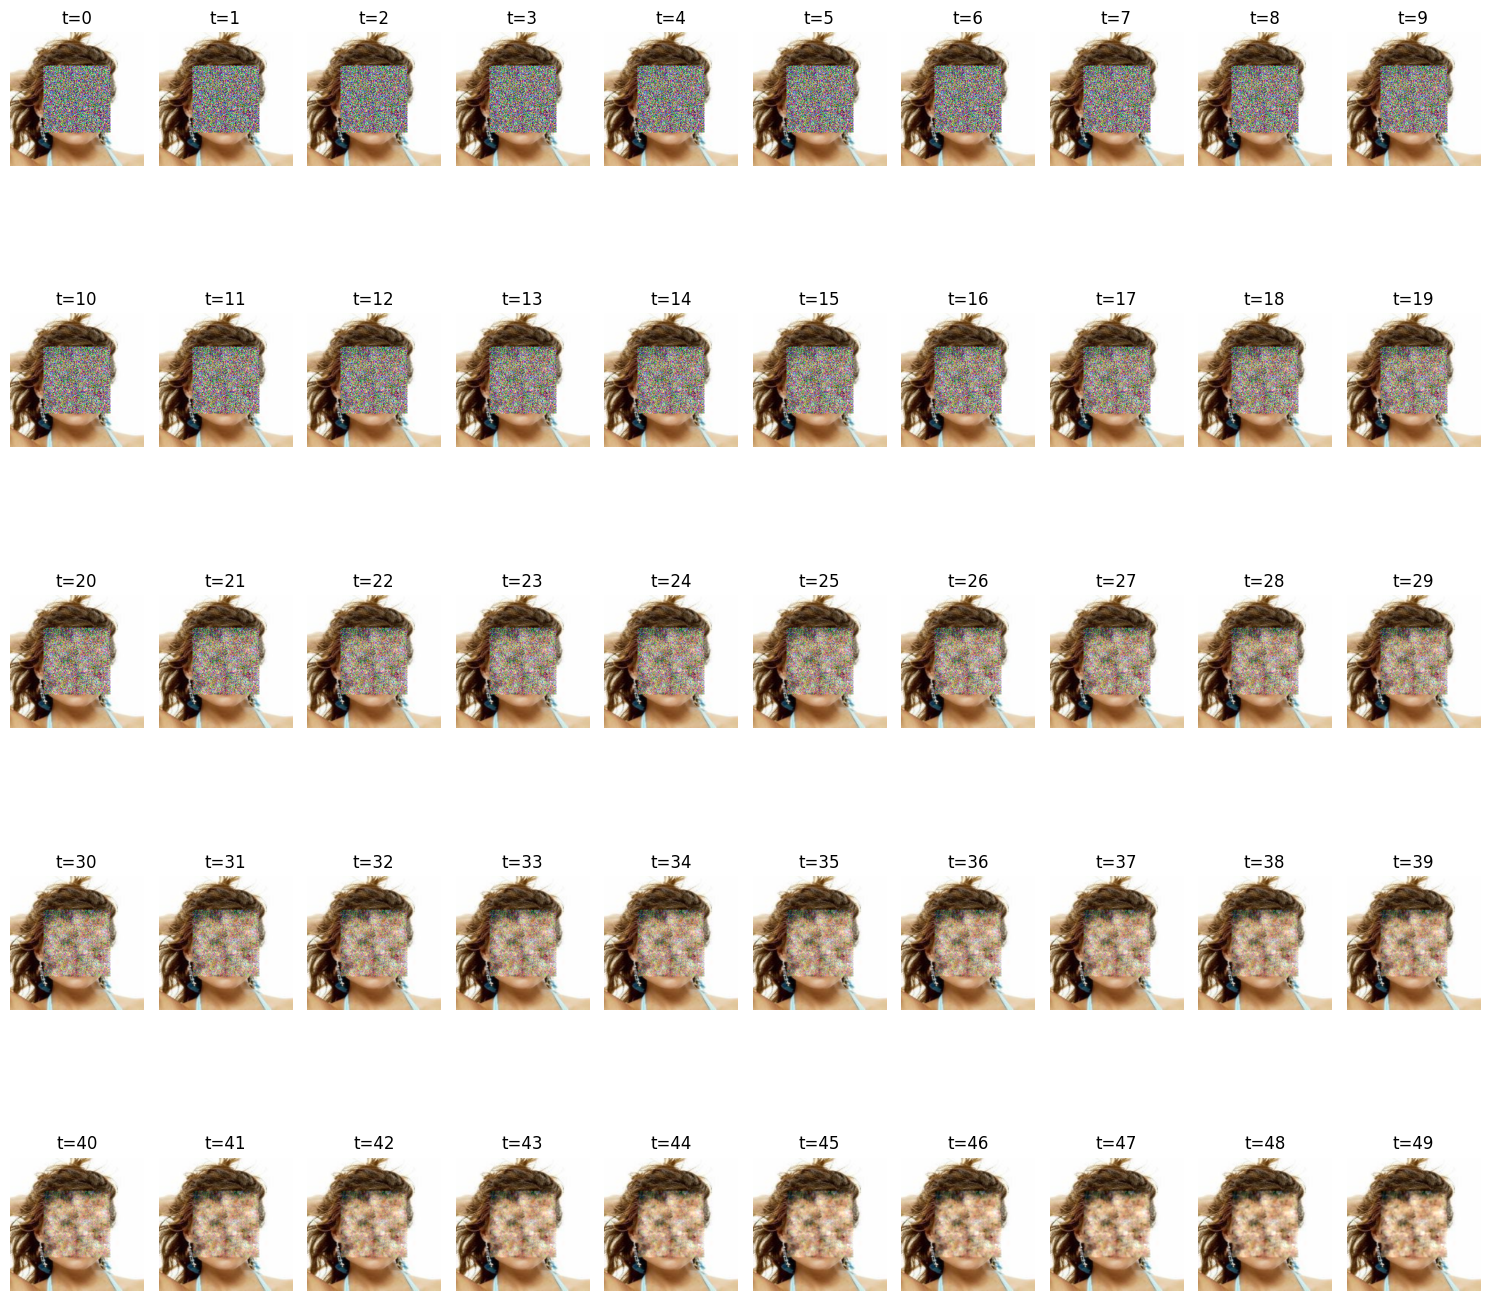

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchcfm.models.unet import UNetModel
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.eval()

def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1,)
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image * (1. - mask) + mask * y # trung tâm :y hiện tại # rìa : ảnh gốc
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image * (1. - mask) + mask * noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # 50 time steps từ 0 đến 1
dt = t_steps[1] - t_steps[0]  # bước thời gian

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

# -------------------------------
# Visualize the generated trajectory using matplotlib

# Chuyển traj về CPU và numpy
traj_np = traj.cpu().numpy()  # shape: (n_steps, batch, C, H, W)
# Lấy ví dụ sample đầu tiên trong batch
traj_sample = traj_np[:, 0, :, :, :]  # shape: (n_steps, C, H, W)
n_steps = traj_sample.shape[0]

# Tạo lưới hiển thị, ví dụ 10 ảnh trên 1 hàng
cols = 10
rows = int(np.ceil(n_steps / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

for i in range(n_steps):
    img = traj_sample[i]  # (C, H, W)
    # Chuyển về (H, W, C)
    img = np.transpose(img, (1, 2, 0))
    # De-normalize: ảnh ban đầu được normalize với mean=0.5, std=0.5 nên:
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"t={i}")

# Xóa các trục không cần thiết nếu subplot dư
for j in range(n_steps, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
